<a href="https://colab.research.google.com/github/trungnt13/uef_bay1_2018/blob/master/ex4_sampler/ex5_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install daft seaborn PyDrive

    100% |████████████████████████████████| 993kB 18.5MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
# Prepare the libraries for the exercise
import matplotlib
from matplotlib import pyplot as plt
import daft
import seaborn

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_probability as tfp
tfd = tfp.distributions
np.random.seed(5218)

#### If you have trouble with mathematic mode in latex, following links are very good for reference!

[Basic](https://en.wikibooks.org/wiki/LaTeX/Mathematics)

[Advance](https://en.wikibooks.org/wiki/LaTeX/Mathematics)

# Question 1 

Considering the directed graphical of Gaussian mixture model explained in the lectures. By making use of the d-separation criterion, show that posterior distribution of the latent variables factorizes with respect to the different data points. i.e.

\begin{align}
p(\mathbf{Z} \mid \mathbf{X}, \mathbf{\mu}, \sigma^2, \pi) = 
\prod_{n=1}^N p(z_n \mid x_n, \mathbf{\mu}, \sigma^2, \pi)
\end{align}

*Figure 9.6*, page 433, "Pattern Recognition and Machine Learning", M.Bishop 

Graphical representation of a Gaussian mixture model for a set of $N$ i.i.d. data points $\{x_n\}$, with corresponding latent points $\{z_n\}$, where $n = 1,...,N$.

![alt text](https://drive.google.com/uc?export=view&id=1ezGmJ8iqUm6AM_MxEK7n4x9f0DfsmCQv =240x200)

# Question 2

Implement Gibbs sampler for Gaussian mixture models as defined in the lectures. 

Test it using your previously generated synthetic data.

### The following code is used for generating synthetic data

The `gmm` method will generate 1-D data for a given value of `alpha` and `sigma0`

Your task is to implement Gibbs sampling to infer the value of `alpha` and `sigma0` from returned data `X`

NOTE: only `X` should be used, `Z` is returned only for plotting

In [0]:
def gmm(batch_size, n_clusters, alpha, sigma0):
  """ This is the solution for the process in 1.3 (only for 1-D data) """
  # parameters for Dirichlet distribution
  alpha = np.full(shape=(n_clusters,), fill_value=alpha, dtype='float32')

  # step 1: generate the assignment probability
  dirichlet = tfd.Dirichlet(concentration=alpha)
  theta = dirichlet.sample()

  # step 2: generate the centroid for each cluster
  normal_1 = tfd.Normal(loc=[0], scale=sigma0)
  # sampling `n_clusters` time, hence, mean for each cluster
  mu_k = normal_1.sample(n_clusters) # (n_clusters, n_dim)

  # ====== Now for the assignment, need 1 indicator for each
  # examples, hence we need `batch_size` amount of indicator
  # (step: 3(a))====== #
  categorical = tfd.OneHotCategorical(probs=theta)
  z = categorical.sample(batch_size) # (batch_size, n_clusters)
  z = tf.cast(z, tf.bool)

  # ====== sampling the data points (step: 3(b)) ====== #
  normal_2 = tfd.Normal(loc=mu_k, scale=1)
  # this make each draw sample will generate sample for
  # all 4 components
  normal_2 = tfd.Independent(normal_2, reinterpreted_batch_ndims=2)
  x_all_components = normal_2.sample(batch_size) # (batch_size, n_clusters, n_dim)
  # ====== selecting the right component for each sample (step: 3(b)) ====== #
  # (batch_size, n_clusters, n_dim) * (batch_size, n_clusters)
  # = (batch_size, n_dim)
  x = tf.boolean_mask(x_all_components, z)

  # ====== Return: X, Z, mu_k, theta ====== #
  return (x.numpy(),
          np.argmax(z.numpy(), axis=-1),
          mu_k.numpy(),
          theta.numpy())


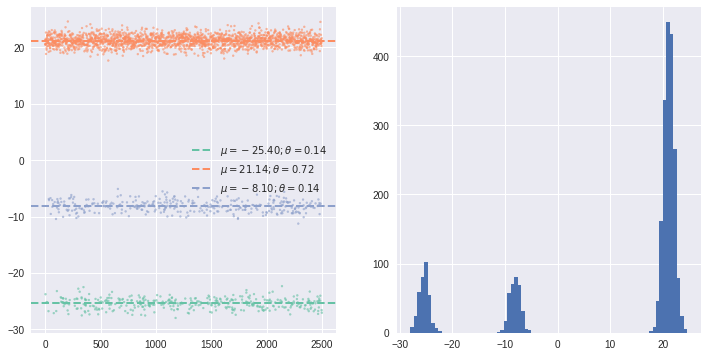

In [0]:
X, Z, mu_k, theta = gmm(2500, n_clusters=3, alpha=1, sigma0=40)

plt.figure(figsize=(12, 6))
colors = seaborn.color_palette(palette='Set2', n_colors=len(np.unique(Z)))
plt.subplot(1, 2, 1)
# plotting the scatter points
plt.scatter(np.arange(len(X)), X, c=[colors[int(z)] for z in Z],
            s=4, alpha=0.6)
# plotting the mean
for i, mu in enumerate(mu_k):
  plt.axhline(mu, 0, len(X),
              label=r"$\mu=%.2f;\theta=%.2f$" % (mu_k[i], theta[i]),
              color=colors[i], linestyle='--', linewidth=2)
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
_ = plt.hist(X, bins=80)

### Gibbs sampling for GMM

From the above figure, $\mu$ and $\theta$ are the unknown quantities you need to infer using Gibbs sampling

The algorithm in outline:

* sample $\mu$ from $\mu \mid x,z,\theta$
* sample $\theta$ from $\theta \mid x,z,\mu$
* sample $z$ from $z \mid x,\theta,\mu$


# Question 3

Perform Gaussian mixture model inference on the fish data. 

Fishes have been kept in different tanks (tankki) and in one tank same type feeding is used. 

All fishes are supposed to be same species, but some might be wild and others grown in the tanks. 

So can we see two different modes in the length distributions? And are there differences between tanks? 

So fit 2-component GMM to fish length (pituus) in each tank (tankki) separately. 

Use your favourite GMM estimator, preferably Gibbs sampler (you can get posterior of means). 

What do you conclude? 

Data is described in the following paper 
(Harkonen, L., Hyvarinen, P., Mehtatalo, L. Vainikka, A. 2017. Growth, survival and social learning in the first hatchery generation of Eurasian perch (Perca fluviatilis). Aquaculture 466: 6471. http://dx.doi.org/10.1016/j.aquaculture.2016.09.027. )

### Read the csv dataset from Google Drive

Link to the data from Google Drive:

https://drive.google.com/open?id=1t-vN62A2oO3HkcZKq1cgYu8m5tuooU6-

In [0]:
# Here: all the package we need to connect to Google Drive using PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 2. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': "1t-vN62A2oO3HkcZKq1cgYu8m5tuooU6-"})
downloaded.GetContentFile('fish.csv')

/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:140: ResourceWarning: unclosed <ssl.SSLSocket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 35234), raddr=('74.125.142.84', 443)>
  if _check_adc():


### Use `pandas` package to load and do data analysis.

Important detail when you are preprocessing the data:

*   Only get sample with MITTAUSAIKA = "LOPETUS"
*  Remove all columns contain NaN (not-a-number) values


           Tyyppi      Taimen  TyyppiTaimen  Allastoisto       Allas  \
count  241.000000  241.000000    241.000000   241.000000  241.000000   
mean     1.331950    1.551867      2.887967     1.510373  820.676349   
std      0.471893    0.498337      1.106750     0.500933    2.621033   
min      1.000000    1.000000      1.000000     1.000000  817.000000   
25%      1.000000    1.000000      2.000000     1.000000  818.000000   
50%      1.000000    2.000000      3.000000     2.000000  821.000000   
75%      2.000000    2.000000      4.000000     2.000000  823.000000   
max      2.000000    2.000000      4.000000     2.000000  824.000000   

           Pituus       Paino   Condition  
count  241.000000  241.000000  241.000000  
mean   132.709544   27.641909    0.822394  
std     22.483296   17.972593    0.206725  
min     88.000000    5.200000    0.375761  
25%    110.000000    9.200000    0.607839  
50%    135.000000   28.400000    0.914540  
75%    150.000000   39.000000    0.979346  

/usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2389: ResourceWarning: unclosed <ssl.SSLSocket fd=96, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 52550), raddr=('74.125.20.95', 443)>
  self.input_dims = a.input_dims
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:192: ResourceWarning: unclosed <ssl.SSLSocket fd=97, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 51522), raddr=('74.125.20.95', 443)>
  super(Text, self).update(kwargs)
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:192: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 51520), raddr=('74.125.20.95', 443)>
  super(Text, self).update(kwargs)
/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:192: ResourceWarning: unclosed <ssl.SSLSocket fd=99, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, 

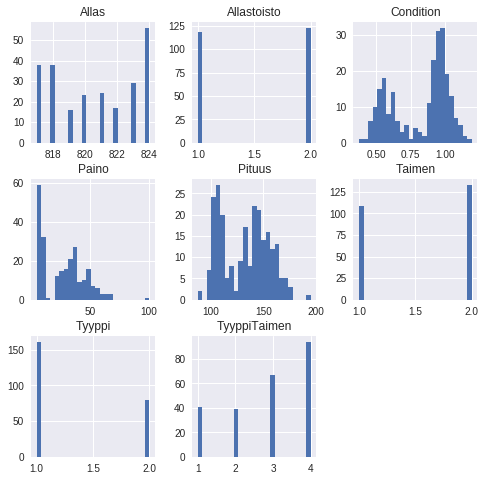

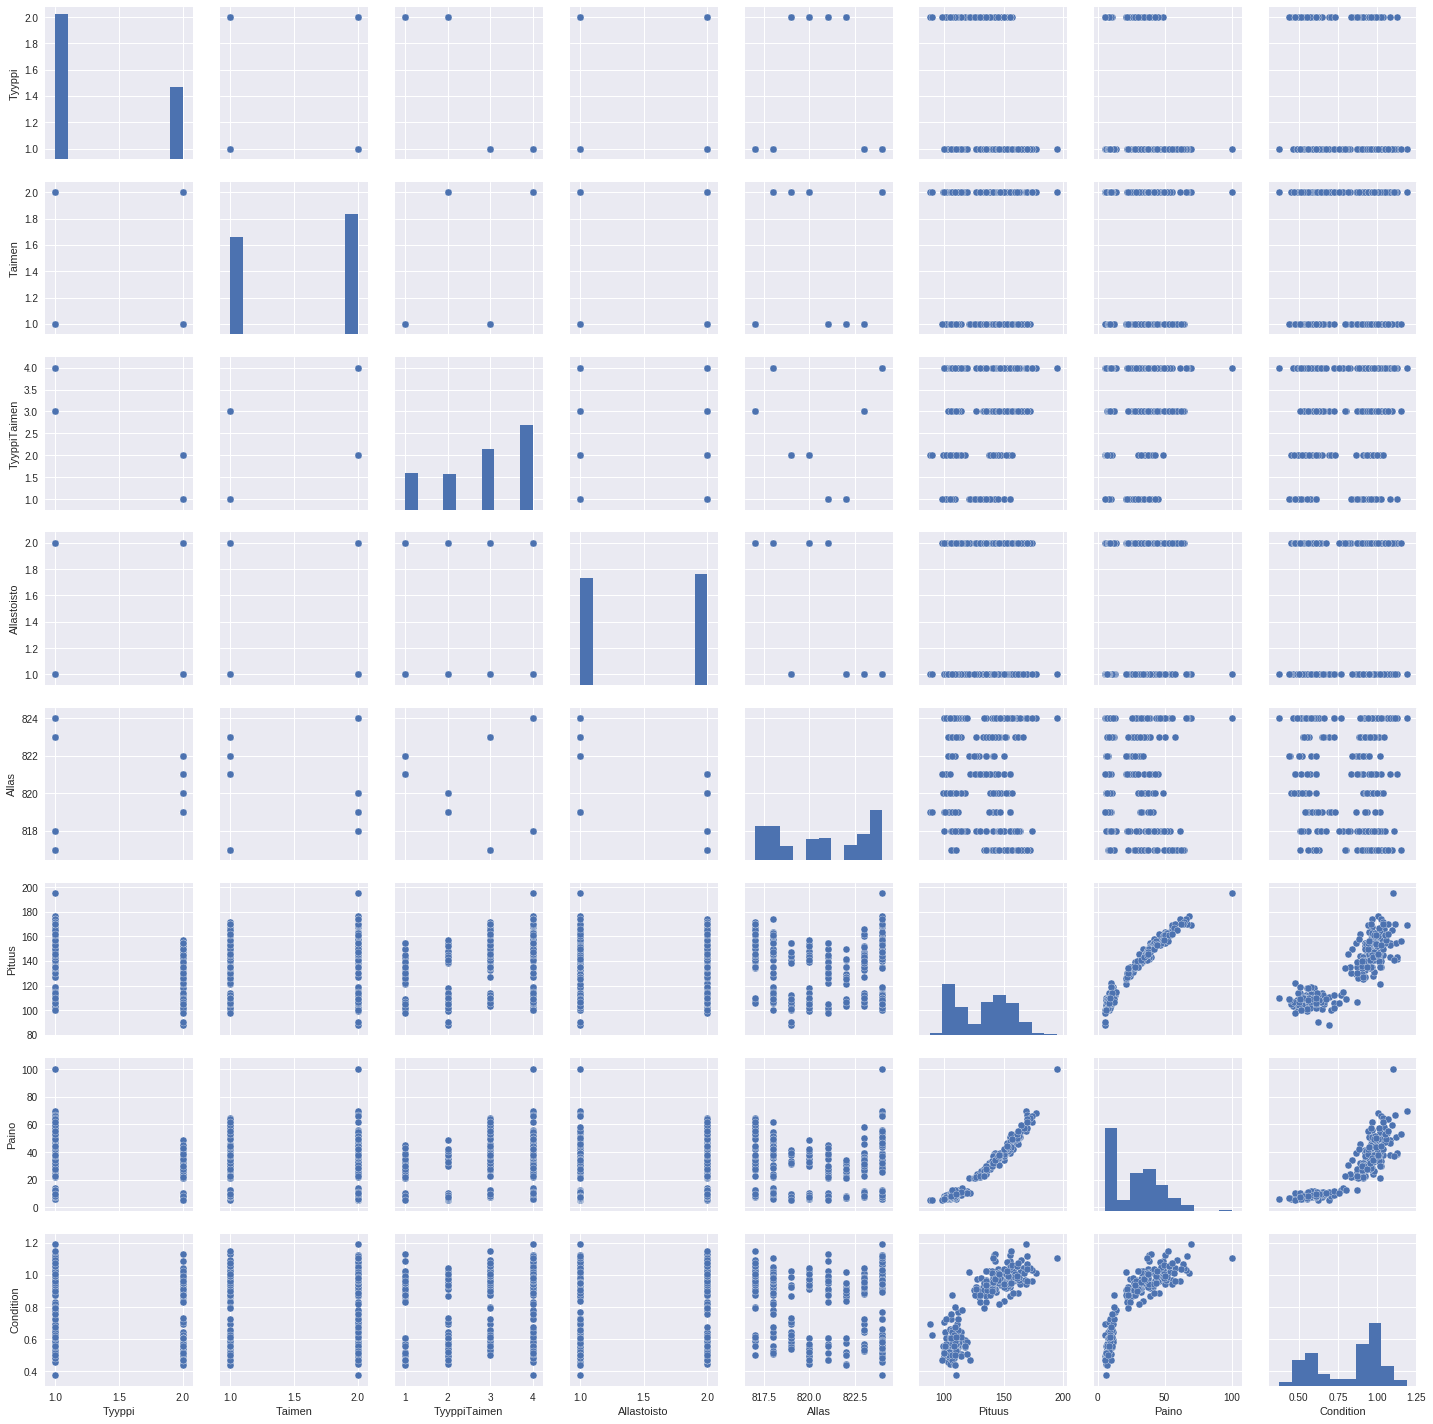

In [0]:
import pandas as pd

ds = pd.read_csv('fish.csv',
                 sep=";", decimal=',', encoding="Latin-1")
# remove all column that contain NaN values
ids = ds.apply(lambda x: np.all(x.notna()), axis=0)
ds = ds.iloc[:, ids.tolist()]
# we only take sample with "MITTAUSAIKA" = "LOPETUS"
selected_row = ds.MITTAUSAIKA == "LOPETUS"
ds = ds[selected_row]
print(ds.describe())

_ = ds.hist(figsize=(8, 8), bins=25)
_ = seaborn.pairplot(ds)

### Fitting GMM model

NOTE: the *curve blue line* is fitted using KDE (kernel density estimation), a non-parametric algorithm for estimating the density of input data. 

KDE is different from GMM (a parametric algorithm), and should not be mistaken as GMM.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

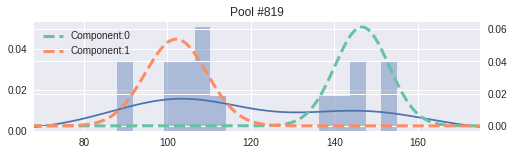

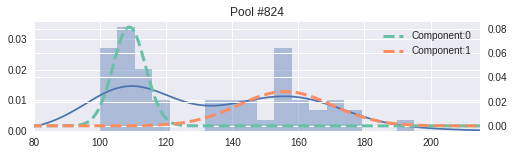

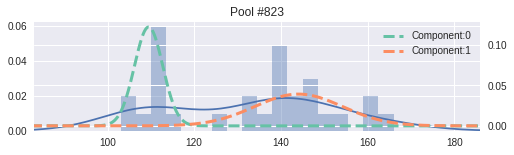

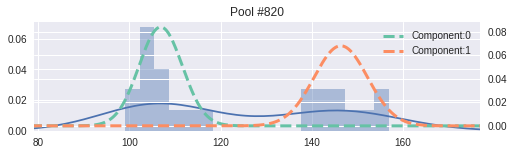

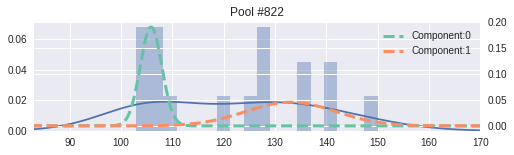

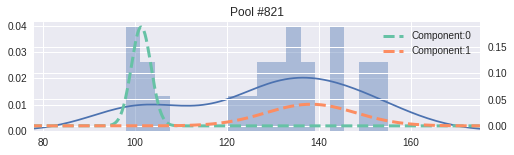

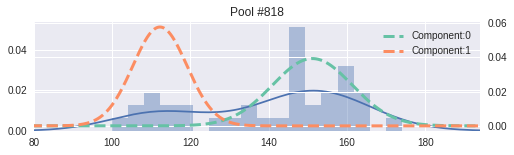

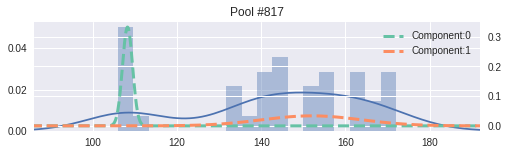

In [0]:
# ====== Getting the tank and fish length data ====== #
# Pituus: length
# Paino : weight
data = ds[['Allas', 'Pituus']]
# ====== grouping the data by the Tank ====== #
from sklearn.mixture import GaussianMixture
n_components = 2
# selecting random color for each component
colors = seaborn.color_palette(
    palette='Set2', n_colors=n_components)
# we need this to draw Gaussian distribution
import matplotlib.mlab as mlab

for pool_id in data.Allas.unique():
  # select all data from given tank
  pool_data = data.Pituus[data.Allas == pool_id]

  # Fitting Gaussian on Pool data
  gmm = GaussianMixture(n_components=int(n_components),
                        covariance_type='diag', n_init=8,
                        random_state=5218)
  # the input data must be at least 2D, so we
  # need to do some preprocessing
  pool_data = np.atleast_2d(pool_data.values).T
  gmm.fit(pool_data)

  # Plotting the histogram
  plt.figure(figsize=(8, 2))
  seaborn.distplot(pool_data, bins=18)

  # Visualizing the GMM
  mean = gmm.means_.ravel()
  precision = gmm.precisions_.ravel()
  xmin, xmax = plt.gca().get_xlim()
  X = np.linspace(start=xmin, stop=xmax,
                  num=1000)
  ax = plt.gca().twinx()
  for n in range(n_components):
    Y = mlab.normpdf(X, mean[n], np.sqrt(1 / precision[n]))
    _, = ax.plot(X, Y,
                 label='Component:%d' % n,
                 color=colors[n], linewidth=3, linestyle='--')

  # show extra info
  ax.set_xlim((np.min(pool_data) - 20,
               np.max(pool_data) + 20))
  plt.legend()
  plt.title("Pool #%s" % str(pool_id))